In [1]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',500)
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,GroupKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [146]:
#External Data
# state GDP: https://en.wikipedia.org/wiki/List_of_Malaysian_states_by_GDP
state_gdp = {
    41336: 116.679,
    41325: 40.596,
    41367: 23.02,
    41401: 190.075,
    41415: 5.984,
    41324: 37.274,
    41332: 42.389,
    41335: 52.452,
    41330: 67.629,
    41380: 5.642,
    41327: 81.284,
    41345: 80.167,
    41342: 121.414,
    41326: 280.698,
    41361: 32.270
}

# state population: https://en.wikipedia.org/wiki/Malaysia
state_population = {
    41336: 33.48283,
    41325: 19.47651,
    41367: 15.39601,
    41401: 16.74621,
    41415: 0.86908,
    41324: 8.21110,
    41332: 10.21064,
    41335: 15.00817,
    41330: 23.52743,
    41380: 2.31541,
    41327: 15.61383,
    41345: 32.06742,
    41342: 24.71140,
    41326: 54.62141,
    41361: 10.35977
}

state_area ={
    41336:19102,
41325:9500,
41367:15099,
41401:243,
41415:91,
41324:1664,
41332:6686,
41335:36137,
41330:21035,
41380:821,
41327:1048,
41345:73631,
41342:124450,
41326:8104,
41361:13035}


In [426]:
#Read the train and test cleaned data with engineered features
train_copy_df = pd.read_csv('train_complete.csv')
test_copy_df = pd.read_csv('test_complete.csv')

In [427]:
## is right age and is reproductive 
#train_copy_df['IsRightAge'] = train_copy_df['Age'].apply(lambda x : 1 if x <=12 else 0 )
#test_copy_df['IsRightAge'] = test_copy_df['Age'].apply(lambda x : 1 if x <=12 else 0 )

train_copy_df.loc[(train_copy_df['Sterilized']==2) & (train_copy_df['Gender']==2),'IsReproductive'] = 1
train_copy_df['IsReproductive'] = train_copy_df['IsReproductive'].fillna(0)

test_copy_df.loc[(test_copy_df['Sterilized']==2) & (test_copy_df['Gender']==2),'IsReproductive'] = 1
test_copy_df['IsReproductive'] = test_copy_df['IsReproductive'].fillna(0)

In [428]:
##Add high Quality pets by rescuer
train_rows = train_copy_df.shape[0]
test_rows = test_copy_df.shape[0]

con_df = pd.concat([train_copy_df,test_copy_df])
fil = (con_df['Health']==1) & (con_df['Dewormed']==1) & (con_df['Vaccinated']==1)

healthyPetsByEachREscuer = con_df[fil].groupby('RescuerID')['Quantity'].sum()
healthyPetsByEachREscuer = pd.DataFrame({'RescuerID':healthyPetsByEachREscuer.index,'Count':healthyPetsByEachREscuer.values})

con_df['HighQualityPetsByRescuer'] = con_df['RescuerID'].map(healthyPetsByEachREscuer.set_index('RescuerID')['Count'])

con_df['HighQualityPetsByRescuer'] = con_df['HighQualityPetsByRescuer'].fillna(0)
con_df['HighQualityPetsByRescuer'] = con_df['HighQualityPetsByRescuer']/con_df['RescuerNumPosts']
#con_df['HighQualityPetsByRescuer'] = con_df['HighQualityPetsByRescuer'].astype('int')
#Again separate out the train and test sets
train_copy_df = con_df.iloc[:train_rows,]
test_copy_df = con_df.iloc[train_rows:,]
print(train_copy_df.shape)
print(test_copy_df.shape)

(14993, 64)
(3948, 64)


In [429]:
train_copy_df["state_gdp"] = train_copy_df.State.map(state_gdp)
train_copy_df["state_population"] = train_copy_df.State.map(state_population)
test_copy_df["state_gdp"] = test_copy_df.State.map(state_gdp)
test_copy_df["state_population"] = test_copy_df.State.map(state_population)
train_copy_df["state_area"] = train_copy_df.State.map(state_area)
test_copy_df["state_area"] = test_copy_df.State.map(state_area)

In [257]:
cat_cols =['Dewormed','Gender','Health','FurLength','MaturitySize','Sterilized','Vaccinated']

In [159]:
#Read image features from pretrained dense net
train_denseimage_df = pd.read_csv('train_img_features_fromDenseNet.csv')
test_denseimage_df = pd.read_csv('test_img_features_fromDenseNet.csv')
print(train_denseimage_df.shape,test_denseimage_df.shape)

(14993, 257) (3948, 257)


In [ ]:
train_denseimage_df = train_denseimage_df.rename({"Unnamed: 0":"PetID"},axis=1)
test_denseimage_df = test_denseimage_df.rename({"Unnamed: 0":"PetID"},axis=1)
test_denseimage_df.head()

In [167]:
#merge these features will all other features
left = train_copy_df
right = train_denseimage_df
train_copy_df = pd.merge(left,right,on='PetID',how='left')

left = test_copy_df
right = test_denseimage_df
test_copy_df = pd.merge(left,right,on='PetID',how='left')

In [118]:
# #Read the color data from Tobel
# train_colors_df = pd.read_csv('train_colors.csv')
# test_colors_df = pd.read_csv('test_colors.csv')
# test_colors_df = test_colors_df.drop(['Color1','Color2','Color3'],axis=1)
# print(train_colors_df.shape,test_colors_df.shape)

(14993, 10) (3948, 10)


In [119]:
# #Read the Sentiment features from Tobel
# train_sentiments_df = pd.read_csv('train_sentiment_features.csv')
# test_sentiments_df = pd.read_csv('test_sentiment_features.csv')
# train_sentiments_df = train_sentiments_df.drop(['Description'],axis=1)
# test_sentiments_df = test_sentiments_df.drop(['Description'],axis=1)
# print(train_sentiments_df.shape,test_sentiments_df.shape)

(14993, 12) (3948, 12)


In [120]:
#merge these features will all other features
# left = train_copy_df
# right = train_colors_df
# train_copy_df = pd.merge(left,right,on='PetID',how='left')

# left = test_copy_df
# right = test_colors_df
# test_copy_df = pd.merge(left,right,on='PetID',how='left')


In [121]:
#merge these features will all other features
# left = train_copy_df
# right = train_sentiments_df
# train_copy_df = pd.merge(left,right,on='PetID',how='left')

# left = test_copy_df
# right = test_sentiments_df
# test_copy_df = pd.merge(left,right,on='PetID',how='left')
# print(train_copy_df.shape,test_copy_df.shape)

(14993, 82) (3948, 82)


In [122]:
# drop_cols = ['AdoptionSpeed','Description','Name','PetID'
#              ,'Quantity','detectionConfidence','headwearLikelihood','joyLikelihood',
#             'surpriseLikelihood','sorrowLikelihood',
#             'underExposedLikelihood','blurredLikelihood',
#             'angerLikelihood']

In [258]:
#Get Dummies
train_copy_df = pd.get_dummies(train_copy_df,columns=cat_cols)
test_copy_df = pd.get_dummies(test_copy_df,columns=cat_cols)

In [430]:
drop_cols = ['AdoptionSpeed','Description','Name','PetID'
             ,'Quantity']

In [431]:
#Drop description, petid, name
y = train_copy_df['AdoptionSpeed']
X = train_copy_df.drop(drop_cols,axis=1)
test_X = test_copy_df.drop(drop_cols, axis=1)
test_X = test_X.values
print(X.shape,y.shape,test_X.shape)

(14993, 62) (14993,) (3948, 62)


In [406]:
from imblearn.over_sampling import SMOTE

In [433]:
sm = SMOTE(random_state=12, kind='regular')
X, y = sm.fit_sample(X, y)

In [412]:
X[1,:]

array([ 1.000000e+00,  2.650000e+02,  0.000000e+00,  1.000000e+00,
        2.000000e+00,  0.000000e+00,  1.180000e+02,  3.000000e+00,
        0.000000e+00,  2.000000e+00,  1.000000e+00,  1.000000e+00,
        1.000000e+01,  0.000000e+00,  7.000000e-01,  2.000000e+00,
        2.200000e+01,  2.000000e+00,  2.000000e+00,  1.408000e+03,
       -2.000000e-01,  4.140100e+04,  1.000000e+00,  3.000000e+00,
        2.000000e+00,  3.000000e+00,  0.000000e+00,  2.300000e+01,
        1.000000e+00,  3.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  1.000000e+01,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  8.919079e-01,
        8.346149e-01,  0.000000e+00,  6.729947e-01,  9.052969e-01,
        0.000000e+00,  0.000000e+00,  6.582632e-01,  8.416056e-01,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        9.812687e-01,  0.000000e+00,  0.000000e+00,  1.900750e

In [434]:
# Define what will be the final predicted train and test values
train_meta = np.zeros(y.shape)
test_meta = np.zeros(test_X.shape[0])

#SMOTE over samplingg
sm = SMOTE(random_state=12, kind='regular')

# Choose and initialize a model.
clf = XGBClassifier(max_depth=7,n_estimators=250,n_jobs=8)

# Divide the training data into k-folds, k=4 here.
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=1812).split(X, y))

#splits = list(GroupKFold(n_splits=4).split(X, y, X['RescuerID']))

# Loop over the folds and fit the model to the fold's training data.
# Then evaluate that model on i) the validation data of that fold, 
# and ii) on all of the test data.
for idx, (train_idx, valid_idx) in enumerate(splits):
        # The training and validation sets for this fold
#         X_train = X.iloc[train_idx]
#         y_train = y[train_idx]
#         X_val = X.iloc[valid_idx]
#         y_val = y[valid_idx]
        
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_val = X[valid_idx]
        y_val = y[valid_idx]
        
        #x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
        #X_train,y_train = x_train_res,y_train_res
        print(X_train.shape,y_train.shape)
        
        # Fit the model
        clf.fit(X_train, y_train)
        
        # Look at the validation kappa and accuracy with classes right from the model
        y_pred = clf.predict(X_val)
        print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        #
        # Assign real-valued classes in addition to the integer classes of y_pred.
        # Start with the predicted probabilities by class
        y_probs = clf.predict_proba(X_val)
        # and get the class values (use a copy incase we change values)
        class_vals = clf.classes_.copy()
        # Change the ordinal weight of class 0 to be -1 as suggested by the plot in discussion:
        # https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76265
        # Does mot make much difference, though.
        class_vals[0] = -1
        # Create the float class values as the probability-weighted class
        # Here a python "list comprehension" is used rather than a loop.
        y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]
        #   
        # Save these y_float values instead of the y_pred integers;
        ##train_meta[valid_idx] = y_pred.reshape(-1)
        train_meta[valid_idx] = y_floats
        # the predictions for just this validation fold are saved in the train_meta array;
        # looping over all folds will provide one prediction for each training sample.

        # Now use this fold's same model to generate Test predictions.
        ##y_test = clf.predict(test_X)
        # Instead of integer classes, get the predicted probabilites
        
        test_probs = clf.predict_proba(test_X)
        # and turn these into float class values.
        # Unlike the validation case, we get a test prediction from every fold,
        # so those float predictions are averaged. python list comprehension is used again.
        ##test_meta += y_test.reshape(-1) / len(splits)
        test_meta += np.array([sum(test_probs[ix]*class_vals) for
                               ix in range(len(test_probs[:,0]))]) / len(splits)

(15735, 62) (15735,)
Fold 0: accuracy = 56.5%, kappa = 0.6666  (no boundary adjustment)
(15740, 62) (15740,)
Fold 1: accuracy = 57.6%, kappa = 0.6894  (no boundary adjustment)
(15740, 62) (15740,)
Fold 2: accuracy = 57.1%, kappa = 0.6711  (no boundary adjustment)
(15740, 62) (15740,)
Fold 3: accuracy = 57.0%, kappa = 0.6814  (no boundary adjustment)


In [ ]:
#to beat this - depth 7
# Fold 0: accuracy = 43.9%, kappa = 0.3997  (no boundary adjustment)
# Fold 1: accuracy = 43.4%, kappa = 0.4013  (no boundary adjustment)
# Fold 2: accuracy = 43.6%, kappa = 0.3733  (no boundary adjustment)
# Fold 3: accuracy = 43.5%, kappa = 0.3724  (no boundary adjustment)

#Without word count
# Fold 0: accuracy = 44.7%, kappa = 0.4114  (no boundary adjustment)
# Fold 1: accuracy = 43.8%, kappa = 0.4003  (no boundary adjustment)
# Fold 2: accuracy = 43.0%, kappa = 0.3638  (no boundary adjustment)
# Fold 3: accuracy = 43.3%, kappa = 0.3813  (no boundary adjustment)

#Without word count and IsHealthy
# Fold 0: accuracy = 44.1%, kappa = 0.3886  (no boundary adjustment)
# Fold 1: accuracy = 43.4%, kappa = 0.3929  (no boundary adjustment)
# Fold 2: accuracy = 43.5%, kappa = 0.3620  (no boundary adjustment)
# Fold 3: accuracy = 43.8%, kappa = 0.3802  (no boundary adjustment)


#With Tobel's colors features
# Fold 0: accuracy = 43.3%, kappa = 0.3940  (no boundary adjustment)
# Fold 1: accuracy = 43.2%, kappa = 0.3935  (no boundary adjustment)
# Fold 2: accuracy = 43.8%, kappa = 0.3672  (no boundary adjustment)
# Fold 3: accuracy = 44.0%, kappa = 0.3880  (no boundary adjustment)


# Fold 0: accuracy = 41.8%, kappa = 0.3870  (no boundary adjustment)
# Fold 1: accuracy = 42.7%, kappa = 0.3945  (no boundary adjustment)
# Fold 2: accuracy = 42.8%, kappa = 0.3810  (no boundary adjustment)
# Fold 3: accuracy = 41.1%, kappa = 0.3461  (no boundary adjustment)


#Another 4.30
# Fold 0: accuracy = 43.7%, kappa = 0.3984  (no boundary adjustment)
# Fold 1: accuracy = 44.2%, kappa = 0.4047  (no boundary adjustment)
# Fold 2: accuracy = 43.6%, kappa = 0.3642  (no boundary adjustment)
# Fold 3: accuracy = 44.8%, kappa = 0.3919  (no boundary adjustment)

Fold 0: accuracy = 44.4%, kappa = 0.4121  (no boundary adjustment)
Fold 1: accuracy = 43.6%, kappa = 0.3967  (no boundary adjustment)
Fold 2: accuracy = 42.9%, kappa = 0.3608  (no boundary adjustment)
Fold 3: accuracy = 43.6%, kappa = 0.3826  (no boundary adjustment)
    
#n_est = 300 
Fold 0: accuracy = 44.3%, kappa = 0.4134  (no boundary adjustment)
Fold 1: accuracy = 43.8%, kappa = 0.4009  (no boundary adjustment)
Fold 2: accuracy = 42.9%, kappa = 0.3681  (no boundary adjustment)
Fold 3: accuracy = 44.0%, kappa = 0.3843  (no boundary adjustment)
    
Fold 0: accuracy = 45.2%, kappa = 0.4098  (no boundary adjustment)
Fold 1: accuracy = 44.1%, kappa = 0.4019  (no boundary adjustment)
Fold 2: accuracy = 43.9%, kappa = 0.3780  (no boundary adjustment)
Fold 3: accuracy = 43.4%, kappa = 0.3674  (no boundary adjustment)
    
Fold 0: accuracy = 44.2%, kappa = 0.3984  (no boundary adjustment)
Fold 1: accuracy = 44.5%, kappa = 0.3946  (no boundary adjustment)
Fold 2: accuracy = 44.4%, kappa = 0.3750  (no boundary adjustment)
Fold 3: accuracy = 44.4%, kappa = 0.3835  (no boundary adjustment)

In [7]:
def get_class_bounds(y, y_pred, N=5, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

def assign_class(y_pred, boundaries):
    """
    Given class boundaries in y_pred units, output integer class values
    """
    y_classes = np.zeros(len(y_pred))
    for iclass, bound in enumerate(boundaries):
        y_classes[y_pred >= bound] = iclass + 1
    return y_classes.astype(int)

In [436]:
# This cell calculates and plots the kappa (and MSE) vs the class0 fraction adjustment.
# Note that MSE prefers (lower MSE) a class0 fraction near/at 0,
# whereas kappa prefers (higher kappa) a fraction near 1.
# Then the class0 fraction that gives best training kappa is selected.
train_y = y
df_train = train_copy_df
# Save values of kappa, MSE, and accuracy vs the class0 fraction
kappas = []
mses = []
accurs = []
# fractions to try... (could go larger than 1 if desired.)
cl0fracs = np.array(np.arange(0.01,1.001,0.01))
for cl0frac in cl0fracs:
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
    kappas.append(kappa)
    mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
    mses.append(mse)
    accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
    accurs.append(accur)
    
# Use the class0 fraction that gives the highest training kappa
ifmax = np.array(kappas).argmax()
cl0frac = cl0fracs[ifmax]

print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))

ValueError: Found input variables with inconsistent numbers of samples: [14993, 20985]

In [438]:
# Can skip the class0_fraction adjustment and plotting cells above;
# can delete those two cells and just uncomment this line:
cl0frac = 1.0

print("Using class0_fraction = {:.4f}, gives boundaries:".format(cl0frac))
boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
print(boundaries)

train_meta_ints = assign_class(train_meta, boundaries)
kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')

print("Adjusted boundaries give:")
print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
                                100.0*accuracy_score(train_y, train_meta_ints)))

Using class0_fraction = 1.0000, gives boundaries:
[0.6167782545089722, 1.9673608876764774, 2.3862420972436666, 2.869417741894722]
Adjusted boundaries give:
kappa = 0.7117  (with accuracy = 53.0%)


In [439]:
# Confusion Matrix
con_mat = confusion_matrix(train_y, train_meta_ints)

# Look at the number that are on the diagonal (exact agreement)
diag = 0.0
for id in range(5):
    diag += con_mat[id,id]
print("\nConfusion matrix - Columns are prediced 0, predicted 1, etc.\n")
print(con_mat)
print("")
print("\n{2:.2f}% = {0}/{1} are on the diagonal (= accuracy)".format(
        int(diag), con_mat.sum(), 100.0*diag/con_mat.sum()))


Confusion matrix - Columns are prediced 0, predicted 1, etc.

[[3770  242   82   59   44]
 [ 259 1982 1062  590  304]
 [  31 1003 1427 1082  654]
 [ 135  750 1102 1474  736]
 [   2  220  524  992 2459]]


52.95% = 11112/20985 are on the diagonal (= accuracy)


In [440]:
test_meta_ints = assign_class(test_meta, boundaries)
PetID = test_copy_df['PetID']
testAdoptionSpeed = pd.Series(data=test_meta_ints, name="AdoptionSpeed")
# Preparing data for Submission
Submission = pd.concat([PetID,testAdoptionSpeed],axis=1)
Submission.head(40)

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
5,77a490ec9,4
6,28c4b1b13,4
7,d1eada628,3
8,d134dec34,4
9,bcd464bb8,1


In [425]:
Submission.shape

(3948, 2)

In [441]:
Submission.to_csv("Submission23.csv", index=False)

#submission 9 is with depth 10
#submission 10 is depth 7

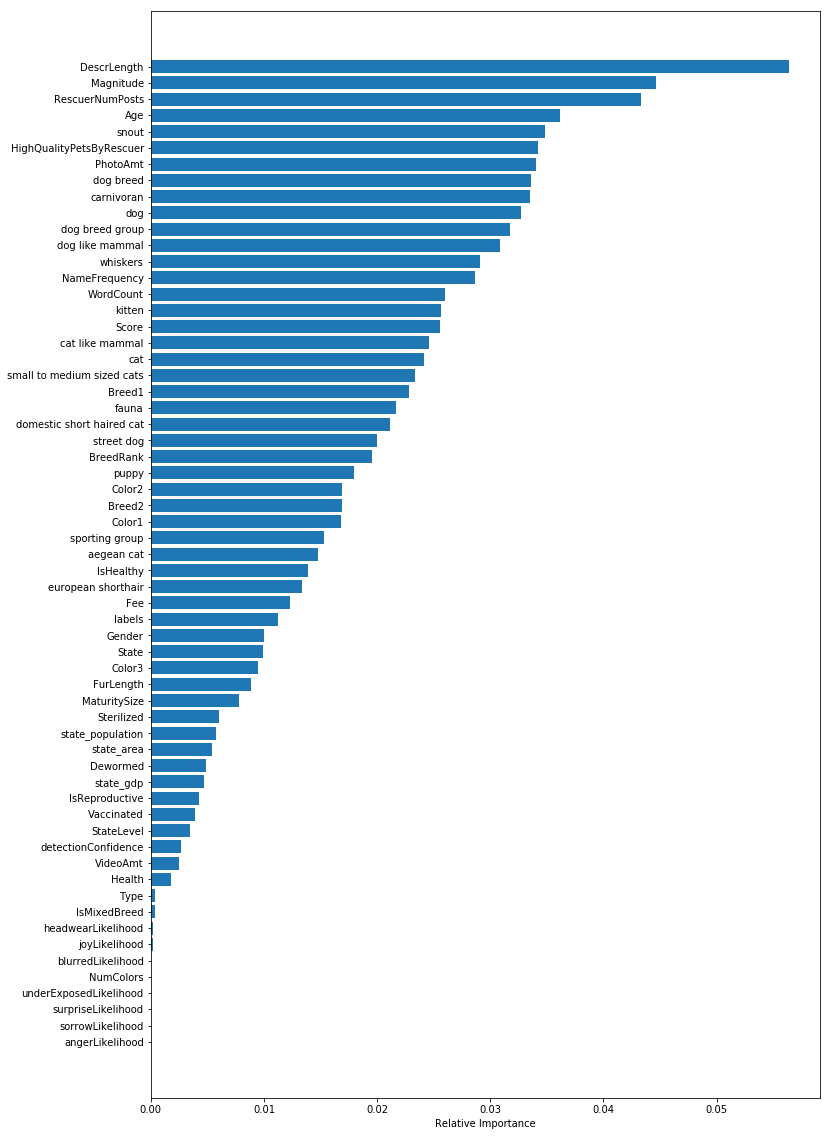

In [374]:
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,20))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.xlabel('Relative Importance')
plt.show()